# **Lesson 04**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# plot parameters
import sys
sys.path.append('./../Libraries/')
import plt_params
%matplotlib inline

# Exercise 04.1

The NSL_SIMULATOR code we have provided compute the total (internal) energy per particle, $E/N$, the potential energy per particle, $U/N$, the kinetic energy per particle, $K/N$, and the temperature, $T$.

Include the calculation of the pressure, $P$, inside your Molecular Dynamics code: block averages, progressive average values and progressive uncertainties.

Remember that, via the **virial theorem**, the pressure in a Lennard-Jones system can be estimated by means of:

$$ P = \rho k_B \langle T \rangle + \frac{1}{3V} \left\langle \sum_{i=1}^{N-1} \sum_{j\,(>i)}^N 48\varepsilon \left[ \left(\frac{\sigma}{|\vec{r}_i -\vec{r}_j|}\right)^{12} - 
\frac{1}{2} \left(\frac{\sigma}{|\vec{r}_i -\vec{r}_j|}\right)^6 \right] \right\rangle $$

# Exercise 04.2

By means of your upgraded code, perform MD simulations via a Lennard-Jones model of Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:
1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

and show in pictures the obtained progressive average values and uncertainties as a functions of the increasing number of blocks for the total (internal) energy per particle, $E/N$, the potential energy per particle, $U/N$, the kinetic energy per particle, $K/N$, the temperature, $T$, and the pressure, $P$, in reduced units!

**Equilibration is needed!**

By monitoring the temperature, $T$, during the first time steps of the simulation, you will observe that at the beginning, starting from a perfect crystalline configuration, $T$ will not conserve its value. Can you understand and explain this behaviour?

Explore and find the starting value of $T$ needed to stabilize, after a certain number of time steps (equilibration time), the average value of $T$ on the desired $T^\star$. Perform your solid/liquid/gas phase MD simulations by re-starting them after such equilibration time.

## Equilibration

In [5]:
eq_solid = np.loadtxt('04.2/Solid/Equilibration/OUTPUT/EQUILIBRATION/temperature_H=0.00_t=1.550.csv', delimiter=',', skiprows=1)
eq_liquid = np.loadtxt('04.2/Liquid/Equilibration/OUTPUT/EQUILIBRATION/temperature_H=0.00_t=1.959.csv', delimiter=',', skiprows=1)
eq_gas = np.loadtxt('04.2/Gas/Equilibration/OUTPUT/EQUILIBRATION/temperature_H=0.00_t=0.956.csv', delimiter=',', skiprows=1)

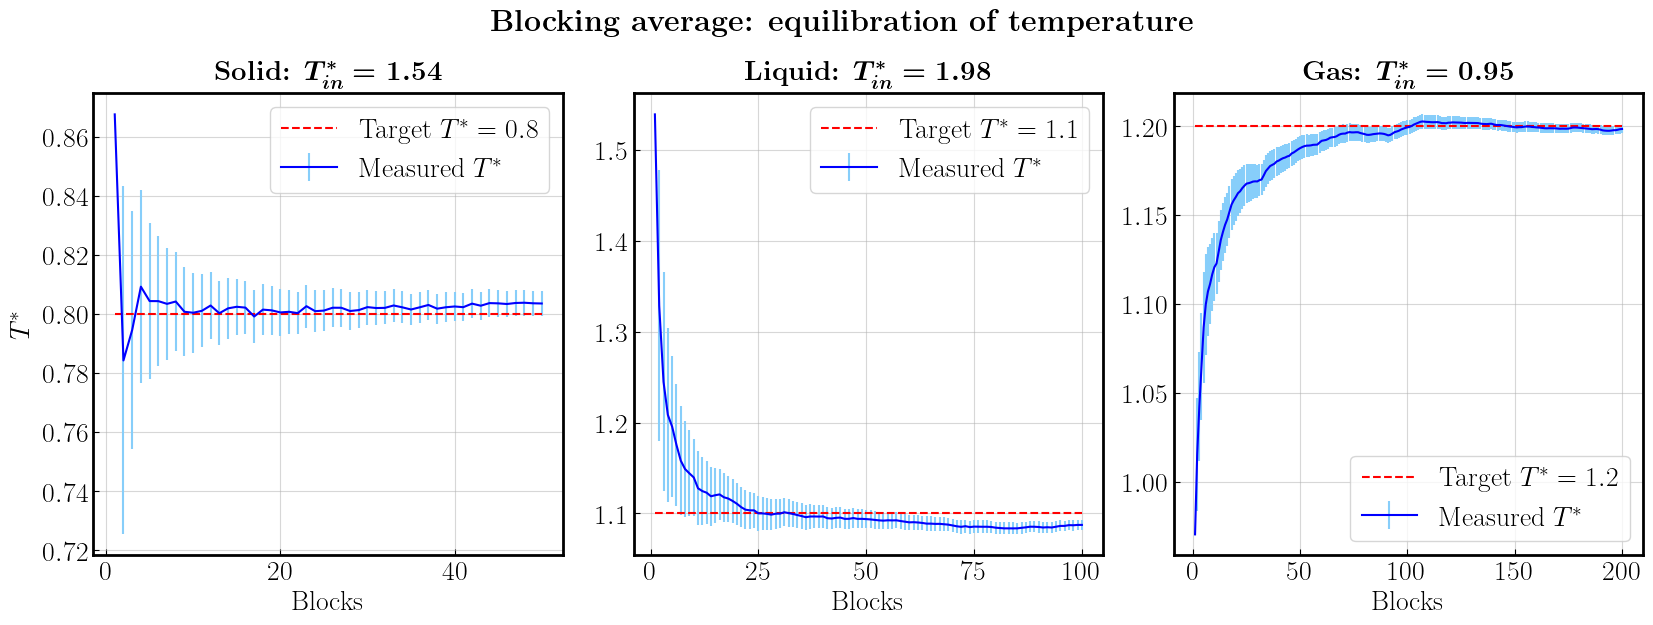

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(20,6), gridspec_kw={'wspace': 0.15})

# solid
axs[0].errorbar(eq_solid[:,0], eq_solid[:,2], yerr=eq_solid[:,3], color='blue', ecolor='lightskyblue', label='Measured $T^*$')
t_solid = np.ones(eq_solid.shape[0])*0.8
axs[0].plot(eq_solid[:,0], t_solid, linestyle='--', color='red', label='Target $T^* = 0.8$')

axs[0].set_title(r'\boldmath \textbf{Solid: $T^*_{in} = 1.54$}', pad=10)
axs[0].set_xlabel('Blocks')
axs[0].set_ylabel('$T^*$', labelpad=6)
axs[0].legend()


# liquid
axs[1].errorbar(eq_liquid[:,0], eq_liquid[:,2], yerr=eq_liquid[:,3], color='blue', ecolor='lightskyblue', label='Measured $T^*$')
t_liquid = np.ones(eq_liquid.shape[0])*1.1
axs[1].plot(eq_liquid[:,0], t_liquid, linestyle='--', color='red', label='Target $T^* = 1.1$')

axs[1].set_title(r'\boldmath \textbf{Liquid: $T^*_{in} = 1.98$}', pad=10)
axs[1].set_xlabel('Blocks')
axs[1].legend()


# gas
axs[2].errorbar(eq_gas[:,0], eq_gas[:,2], yerr=eq_gas[:,3], color='blue', ecolor='lightskyblue', label='Measured $T^*$')
t_gas = np.ones(eq_gas.shape[0])*1.2
axs[2].plot(eq_gas[:,0], t_gas, linestyle='--', color='red', label='Target $T^* = 1.2$')

axs[2].set_title(r'\boldmath \textbf{Gas: $T^*_{in} = 0.95$}', pad=10)
axs[2].set_xlabel('Blocks')
axs[2].legend()

fig.suptitle(r'\textbf{Blocking average: equilibration of temperature}', y=1.02, fontsize=22)
plt.show()

## Simulation

In [8]:
# solid
energy_solid = np.loadtxt('04.2/Solid/Simulation/OUTPUT/total_energy.csv', delimiter=',', skiprows=1)
potential_solid = np.loadtxt('04.2/Solid/Simulation/OUTPUT/potential_energy.csv', delimiter=',', skiprows=1)
kinetic_solid = np.loadtxt('04.2/Solid/Simulation/OUTPUT/kinetic_energy.csv', delimiter=',', skiprows=1)
temperature_solid = np.loadtxt('04.2/Solid/Simulation/OUTPUT/temperature.csv', delimiter=',', skiprows=1)
pressure_solid = np.loadtxt('04.2/Solid/Simulation/OUTPUT/pressure.csv', delimiter=',', skiprows=1)

# liquid
energy_liquid = np.loadtxt('04.2/Liquid/Simulation/OUTPUT/total_energy.csv', delimiter=',', skiprows=1)
potential_liquid = np.loadtxt('04.2/Liquid/Simulation/OUTPUT/potential_energy.csv', delimiter=',', skiprows=1)
kinetic_liquid = np.loadtxt('04.2/Liquid/Simulation/OUTPUT/kinetic_energy.csv', delimiter=',', skiprows=1)
temperature_liquid = np.loadtxt('04.2/Liquid/Simulation/OUTPUT/temperature.csv', delimiter=',', skiprows=1)
pressure_liquid = np.loadtxt('04.2/Liquid/Simulation/OUTPUT/pressure.csv', delimiter=',', skiprows=1)

# gas
energy_gas = np.loadtxt('04.2/Gas/Simulation/OUTPUT/total_energy.csv', delimiter=',', skiprows=1)
potential_gas = np.loadtxt('04.2/Gas/Simulation/OUTPUT/potential_energy.csv', delimiter=',', skiprows=1)
kinetic_gas = np.loadtxt('04.2/Gas/Simulation/OUTPUT/kinetic_energy.csv', delimiter=',', skiprows=1)
temperature_gas = np.loadtxt('04.2/Gas/Simulation/OUTPUT/temperature.csv', delimiter=',', skiprows=1)
pressure_gas = np.loadtxt('04.2/Gas/Simulation/OUTPUT/pressure.csv', delimiter=',', skiprows=1)

In [9]:
solid = [energy_solid, potential_solid, kinetic_solid, temperature_solid, pressure_solid]
liquid = [energy_liquid, potential_liquid, kinetic_liquid, temperature_liquid, pressure_liquid]
gas = [energy_gas, potential_gas, kinetic_gas, temperature_gas, pressure_gas]

data = [solid, liquid, gas]
property = ['Total energy', 'Potential energy', 'Kinetic energy', 'Temperature', 'Pressure']
phase = [r'\textbf{Solid}', r'\textbf{Liquid}', r'\textbf{Gas}']

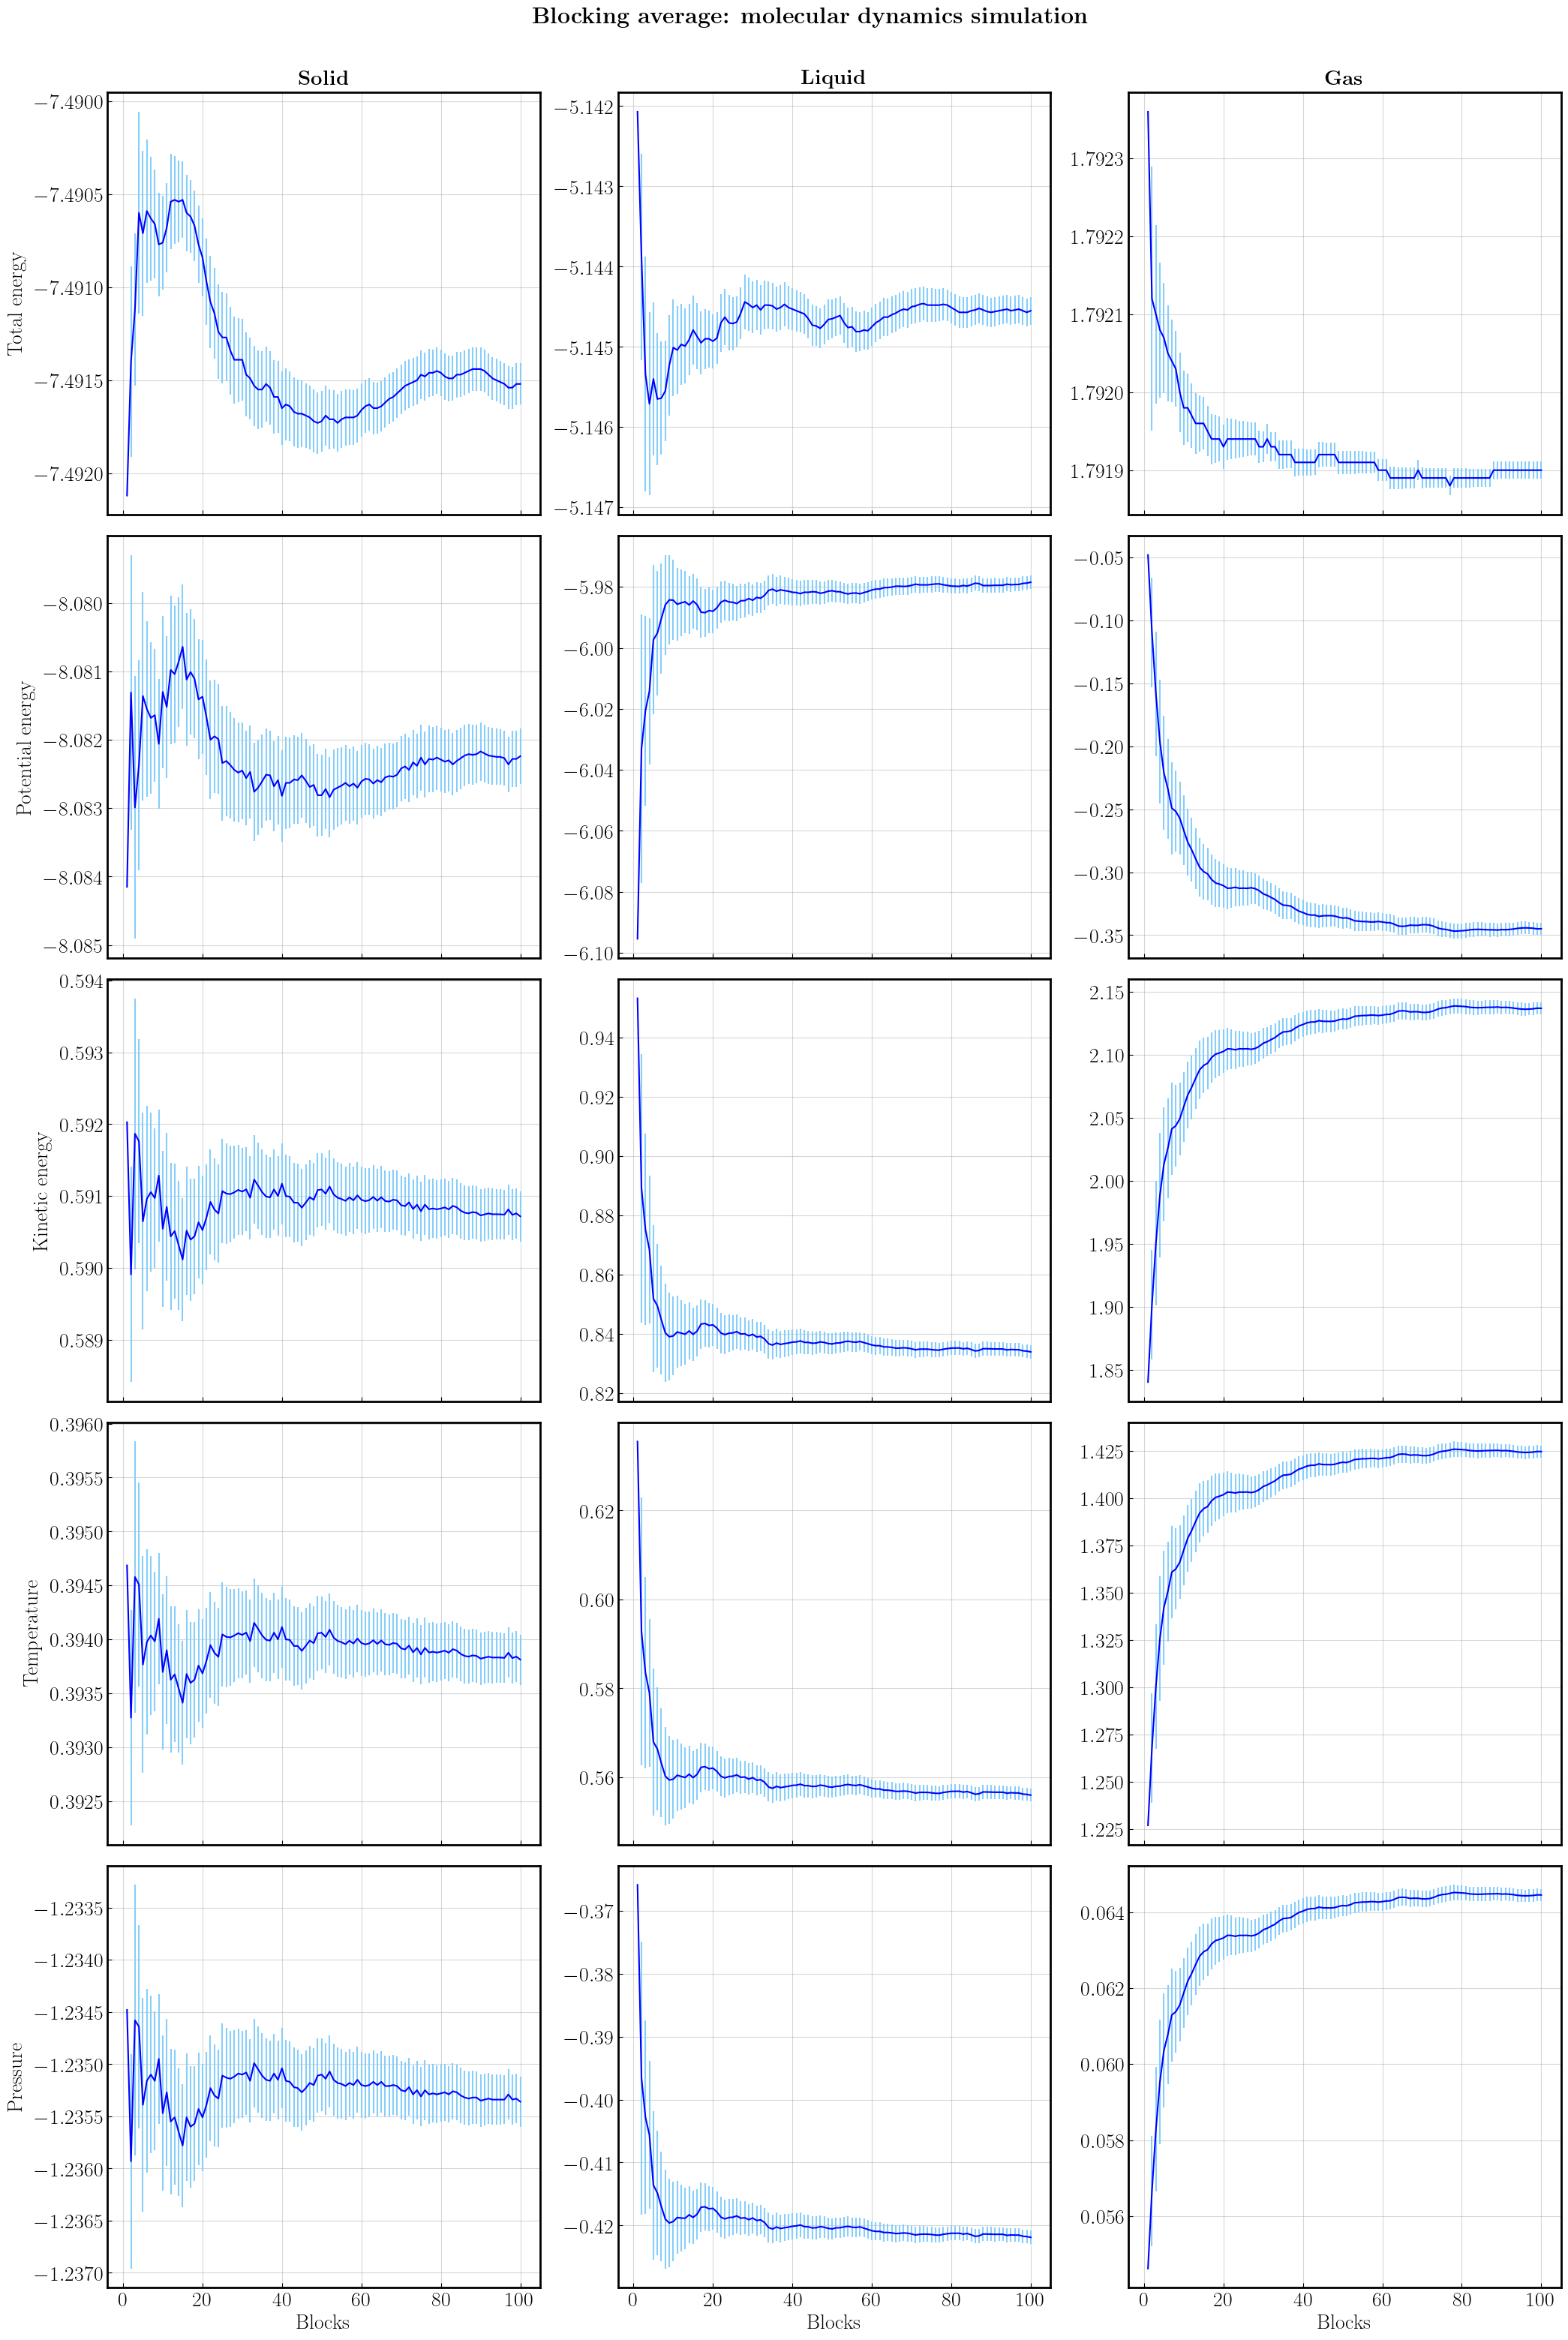

In [10]:
fig, axs = plt.subplots(5, 3, figsize=(25,38), gridspec_kw={'wspace': 0.18, 'hspace': 0.05})

for i in range(3) :
    for j in range(5) :
        axs[j,i].errorbar(data[i][j][:,0], data[i][j][:,2], yerr=data[i][j][:,3], color='blue', ecolor='lightskyblue')
        axs[j,0].set_ylabel(property[j], labelpad=8)
        axs[j,i].set_xticklabels([])
    axs[0,i].set_title(phase[i], pad=8)
    axs[-1,i].set_xticks([0,20,40,60,80,100], ['0','20','40','60','80','100'])
    axs[-1,i].set_xlabel('Blocks')


fig.suptitle(r'\textbf{Blocking average: molecular dynamics simulation}', y=0.91, fontsize=22)
plt.show()

## Equilibration + Simulation ('Both')

In [11]:
eq_solid_b = np.loadtxt('04.2/Solid/Both/OUTPUT/EQUILIBRATION/temperature_H=0.00_t=1.541.csv', delimiter=',', skiprows=1)
eq_liquid_b = np.loadtxt('04.2/Liquid/Both/OUTPUT/EQUILIBRATION/temperature_H=0.00_t=1.977.csv', delimiter=',', skiprows=1)
eq_gas_b = np.loadtxt('04.2/Gas/Both/OUTPUT/EQUILIBRATION/temperature_H=0.00_t=0.956.csv', delimiter=',', skiprows=1)

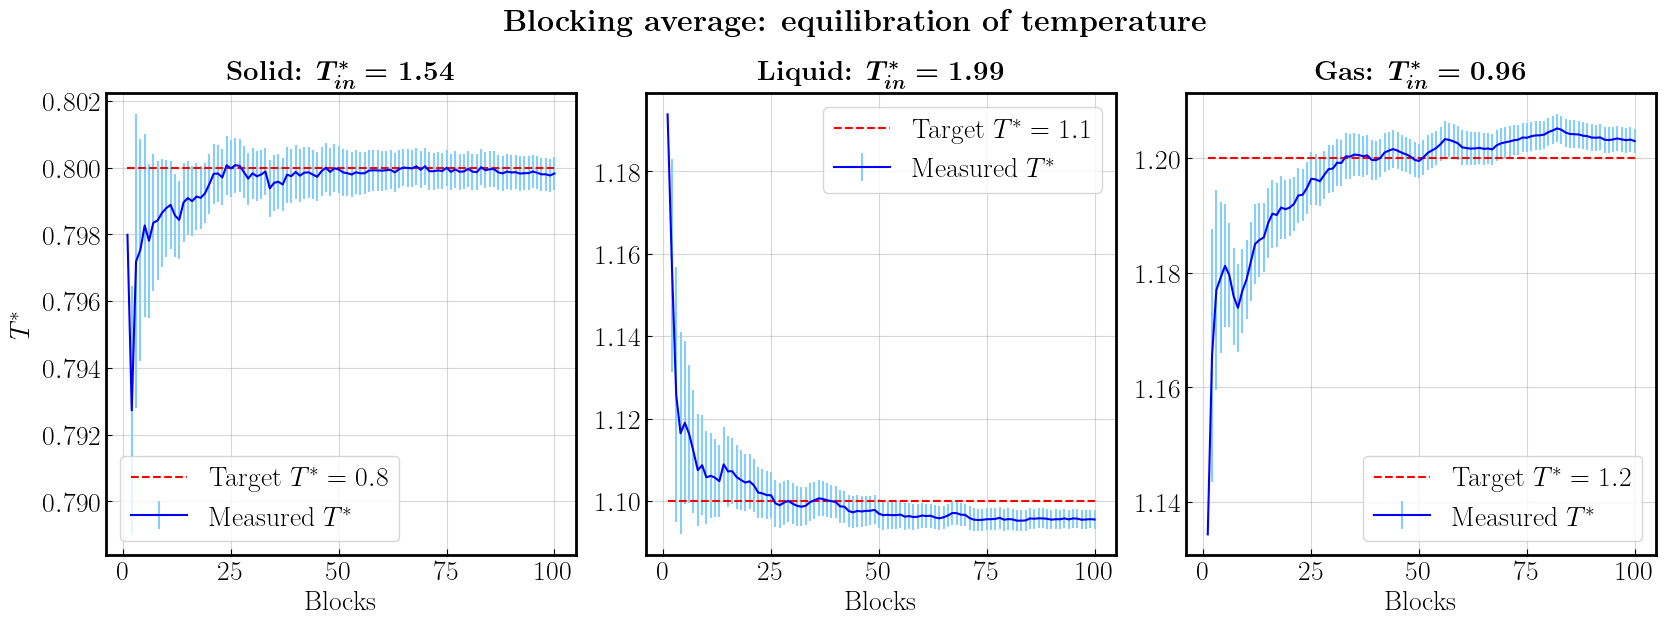

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(20,6), gridspec_kw={'wspace': 0.15})

# solid
axs[0].errorbar(eq_solid_b[:,0], eq_solid_b[:,2], yerr=eq_solid_b[:,3], color='blue', ecolor='lightskyblue', label='Measured $T^*$')
t_solid = np.ones(eq_solid_b.shape[0])*0.8
axs[0].plot(eq_solid_b[:,0], t_solid, linestyle='--', color='red', label='Target $T^* = 0.8$')

axs[0].set_title(r'\boldmath \textbf{Solid: $T^*_{in} = 1.54$}', pad=10)
axs[0].set_xlabel('Blocks')
axs[0].set_ylabel('$T^*$', labelpad=6)
axs[0].legend()


# liquid
axs[1].errorbar(eq_liquid_b[:,0], eq_liquid_b[:,2], yerr=eq_liquid_b[:,3], color='blue', ecolor='lightskyblue', label='Measured $T^*$')
t_liquid = np.ones(eq_liquid_b.shape[0])*1.1
axs[1].plot(eq_liquid_b[:,0], t_liquid, linestyle='--', color='red', label='Target $T^* = 1.1$')

axs[1].set_title(r'\boldmath \textbf{Liquid: $T^*_{in} = 1.99$}', pad=10)
axs[1].set_xlabel('Blocks')
axs[1].legend()


# gas
axs[2].errorbar(eq_gas_b[:,0], eq_gas_b[:,2], yerr=eq_gas_b[:,3], color='blue', ecolor='lightskyblue', label='Measured $T^*$')
t_gas = np.ones(eq_gas_b.shape[0])*1.2
axs[2].plot(eq_gas_b[:,0], t_gas, linestyle='--', color='red', label='Target $T^* = 1.2$')

axs[2].set_title(r'\boldmath \textbf{Gas: $T^*_{in} = 0.96$}', pad=10)
axs[2].set_xlabel('Blocks')
axs[2].legend()

fig.suptitle(r'\textbf{Blocking average: equilibration of temperature}', y=1.02, fontsize=22)
plt.show()

In [13]:
# solid
energy_solid_b = np.loadtxt('04.2/Solid/Both/OUTPUT/total_energy.csv', delimiter=',', skiprows=1)
potential_solid_b = np.loadtxt('04.2/Solid/Both/OUTPUT/potential_energy.csv', delimiter=',', skiprows=1)
kinetic_solid_b = np.loadtxt('04.2/Solid/Both/OUTPUT/kinetic_energy.csv', delimiter=',', skiprows=1)
temperature_solid_b = np.loadtxt('04.2/Solid/Both/OUTPUT/temperature.csv', delimiter=',', skiprows=1)
pressure_solid_b = np.loadtxt('04.2/Solid/Both/OUTPUT/pressure.csv', delimiter=',', skiprows=1)

# liquid
energy_liquid_b = np.loadtxt('04.2/Liquid/Both/OUTPUT/total_energy.csv', delimiter=',', skiprows=1)
potential_liquid_b = np.loadtxt('04.2/Liquid/Both/OUTPUT/potential_energy.csv', delimiter=',', skiprows=1)
kinetic_liquid_b = np.loadtxt('04.2/Liquid/Both/OUTPUT/kinetic_energy.csv', delimiter=',', skiprows=1)
temperature_liquid_b = np.loadtxt('04.2/Liquid/Both/OUTPUT/temperature.csv', delimiter=',', skiprows=1)
pressure_liquid_b = np.loadtxt('04.2/Liquid/Both/OUTPUT/pressure.csv', delimiter=',', skiprows=1)

# gas
energy_gas_b = np.loadtxt('04.2/Gas/Both/OUTPUT/total_energy.csv', delimiter=',', skiprows=1)
potential_gas_b = np.loadtxt('04.2/Gas/Both/OUTPUT/potential_energy.csv', delimiter=',', skiprows=1)
kinetic_gas_b = np.loadtxt('04.2/Gas/Both/OUTPUT/kinetic_energy.csv', delimiter=',', skiprows=1)
temperature_gas_b = np.loadtxt('04.2/Gas/Both/OUTPUT/temperature.csv', delimiter=',', skiprows=1)
pressure_gas_b = np.loadtxt('04.2/Gas/Both/OUTPUT/pressure.csv', delimiter=',', skiprows=1)

In [14]:
solid_b = [energy_solid_b, potential_solid_b, kinetic_solid_b, temperature_solid_b, pressure_solid_b]
liquid_b = [energy_liquid_b, potential_liquid_b, kinetic_liquid_b, temperature_liquid_b, pressure_liquid_b]
gas_b = [energy_gas_b, potential_gas_b, kinetic_gas_b, temperature_gas_b, pressure_gas_b]

data_b = [solid_b, liquid_b, gas_b]
property = ['Total energy', 'Potential energy', 'Kinetic energy', 'Temperature', 'Pressure']
phase = [r'\textbf{Solid}', r'\textbf{Liquid}', r'\textbf{Gas}']

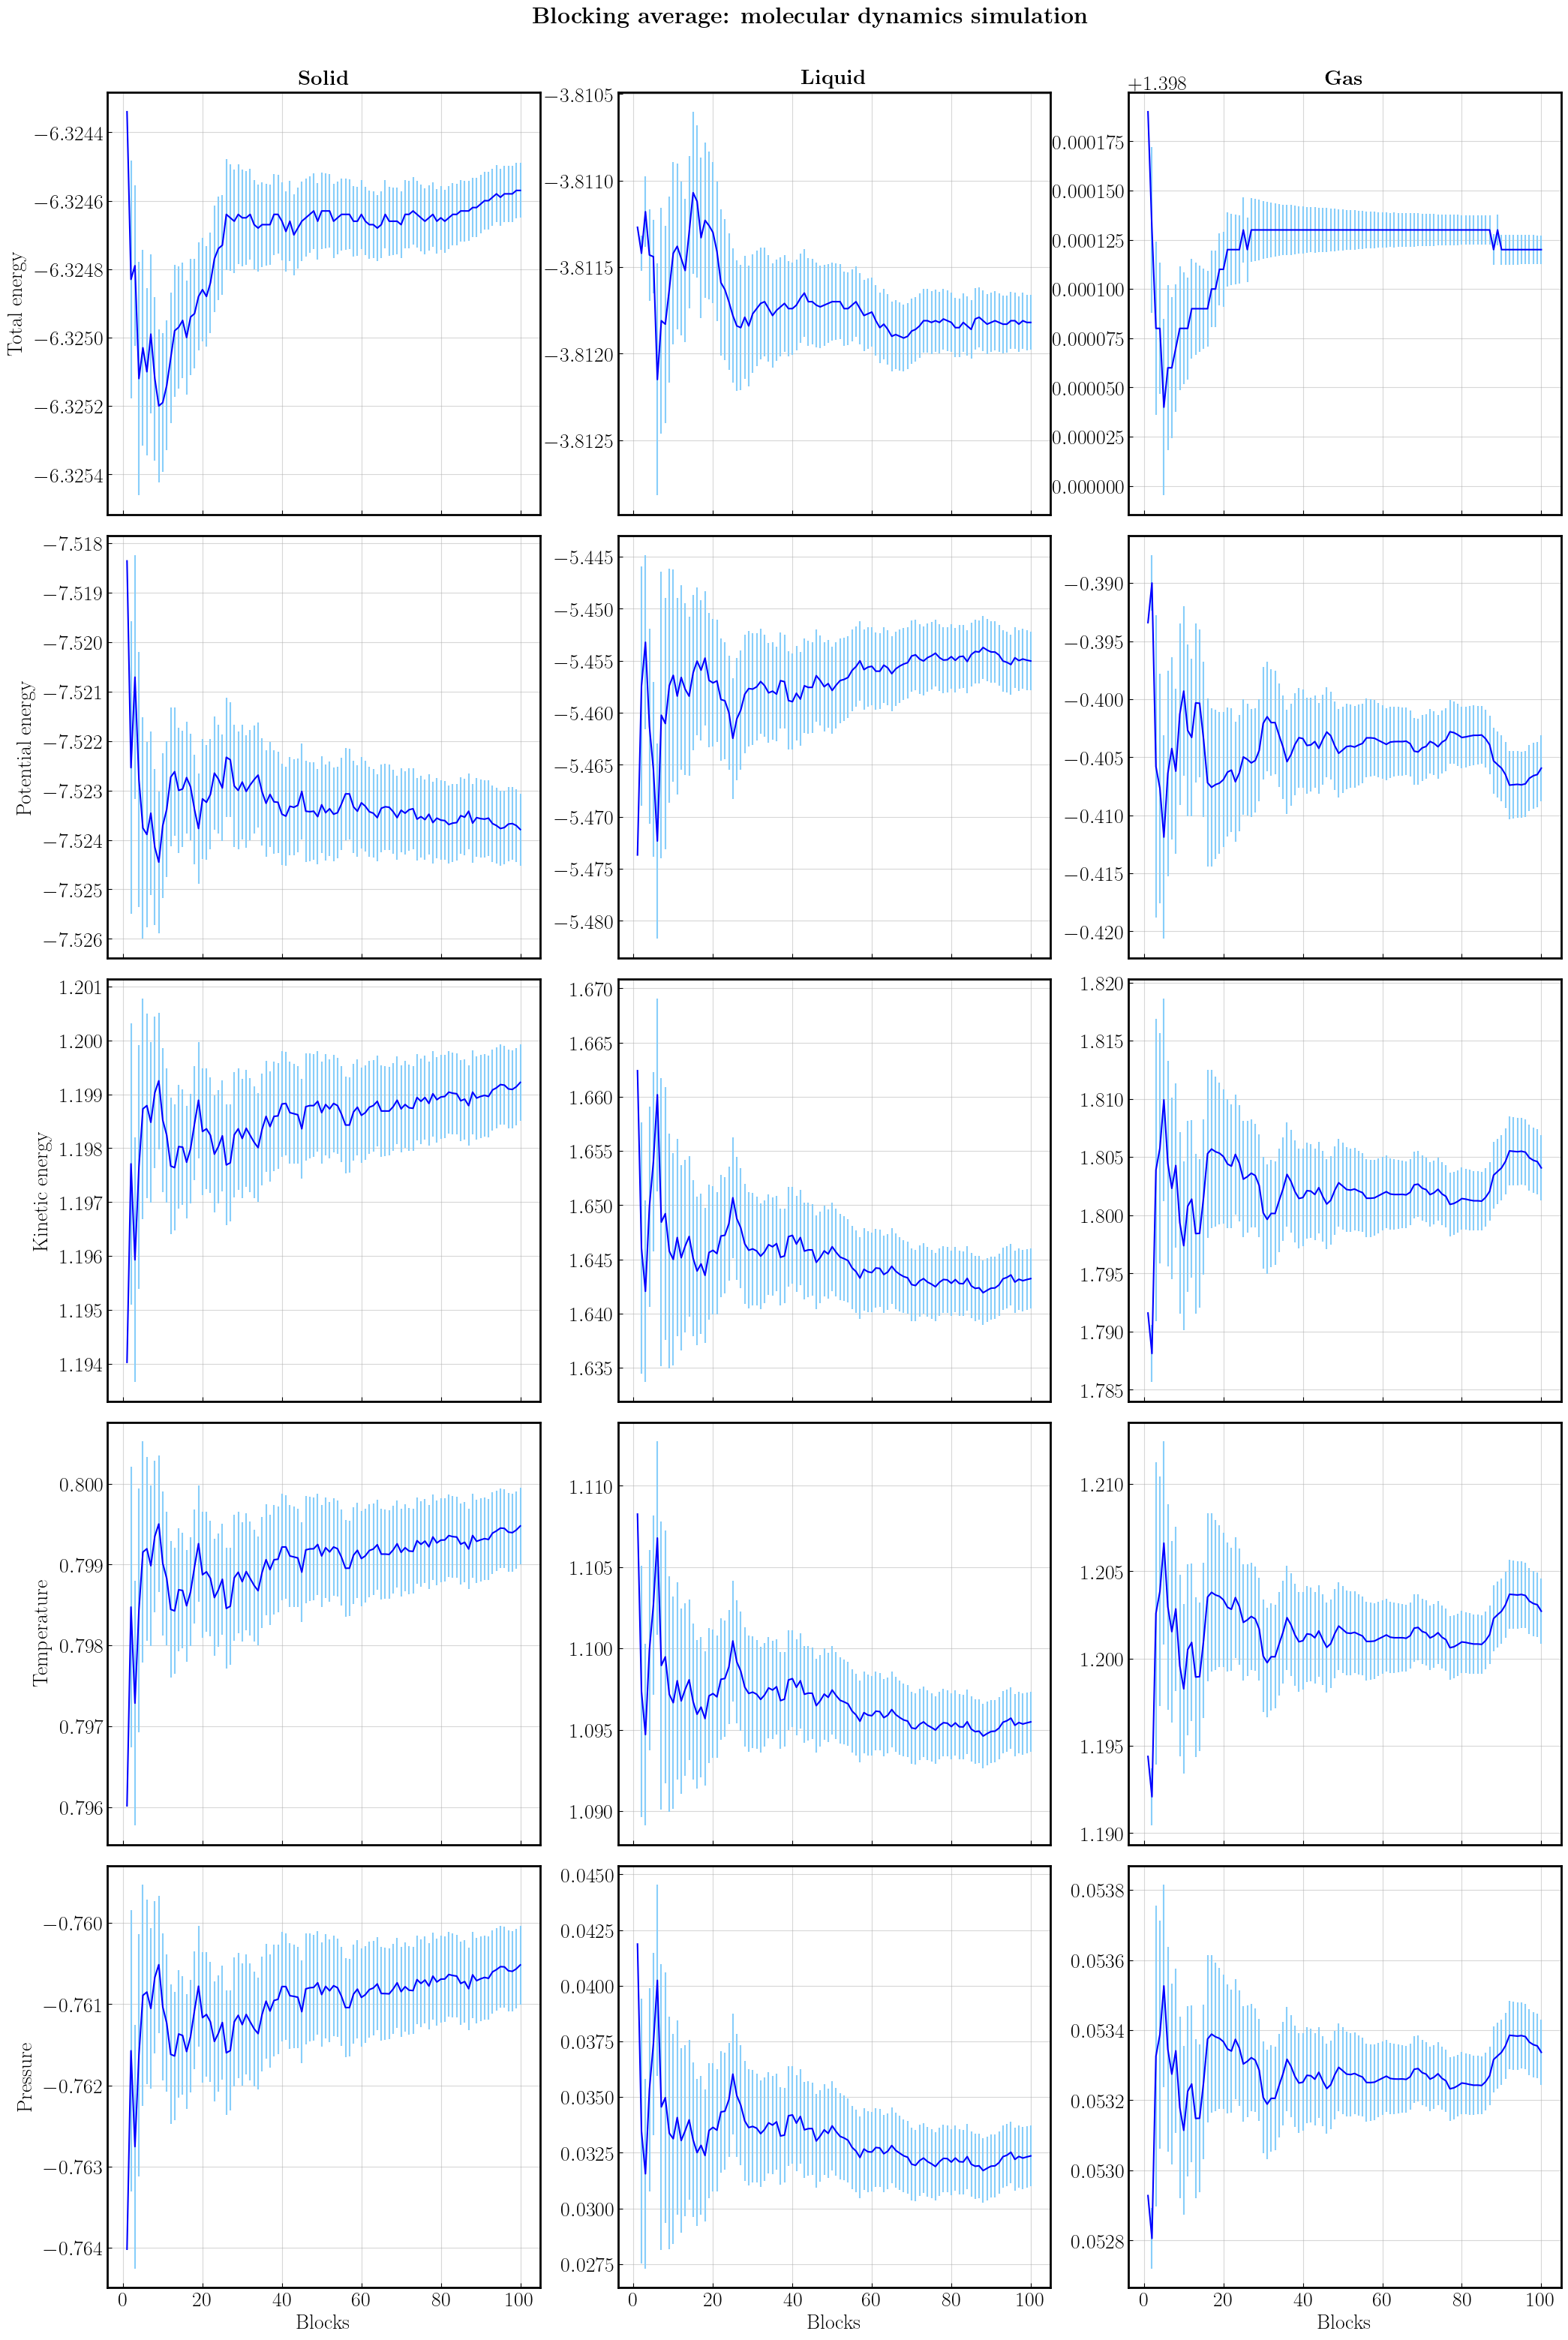

In [15]:
fig, axs = plt.subplots(5, 3, figsize=(25,38), gridspec_kw={'wspace': 0.18, 'hspace': 0.05})

for i in range(3) :
    for j in range(5) :
        axs[j,i].errorbar(data_b[i][j][:,0], data_b[i][j][:,2], yerr=data_b[i][j][:,3], color='blue', ecolor='lightskyblue')
        axs[j,0].set_ylabel(property[j], labelpad=8)
        axs[j,i].set_xticklabels([])
    axs[0,i].set_title(phase[i], pad=8)
    axs[-1,i].set_xticks([0,20,40,60,80,100], ['0','20','40','60','80','100'])
    axs[-1,i].set_xlabel('Blocks')


fig.suptitle(r'\textbf{Blocking average: molecular dynamics simulation}', y=0.91, fontsize=22)
plt.show()